In [1]:
from planet4.clustering import ClusteringManager
from planet4 import p4io as io
from IPython.display import display
from ipywidgets import FloatText
from pathlib import Path

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
db = io.DBManager("/Volumes/Data/planet4/2015-04-26_planet_four_classifications_queryable.h5")
dbname = db.dbname

In [3]:
def process_image_name(img_name):
    from pathlib import Path
    from planet4.clustering import ClusteringManager
    output_dir = Path('/Users/klay6683/Dropbox/data/planet4/inca_p4id_')
    output_dir.mkdir(exist_ok=True)
    cm = ClusteringManager(dbname, scope='planet4',
                           output_dir=output_dir,
                           output_format='both')
    cm.cluster_image_name(img_name)
    return img_name

In [4]:
def process_image_id(img_id):
    from pathlib import Path
    from planet4.clustering import ClusteringManager
    output_dir = Path('/Users/klay6683/Dropbox/data/planet4/inca_p4id_APF0000km4')
    output_dir.mkdir(exist_ok=True)
    cm = ClusteringManager(dbname, scope='planet4',
                           output_dir=output_dir,
                           output_format='both')
    cm.cluster_image_id(img_id)
    return img_id

In [5]:
img_name = 'ESP_021605_0985'

In [6]:
data = db.get_image_name_markings(img_name)

In [7]:
data = data[data.image_id=='APF0000km4']

In [9]:
from planet4 import markings

In [10]:
p4id = markings.ImageID("APF0000km4", data=data)

<IPython.core.display.Javascript object>


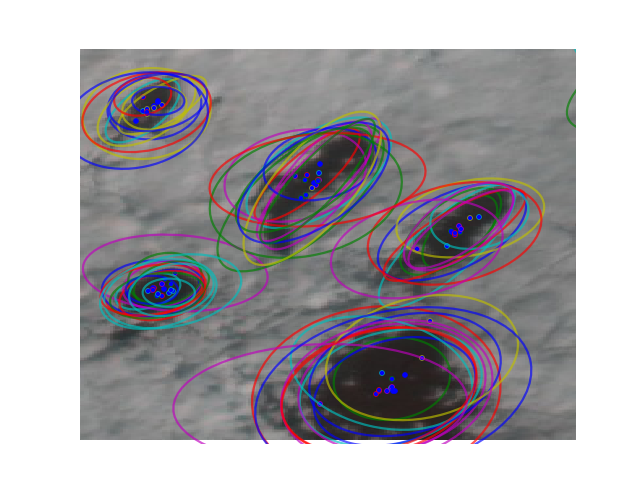

In [16]:
%matplotlib nbagg
p4id.plot_blotches()
plt.savefig('/Users/klay6683/Desktop/blotches_original.pdf')
plt.xlim(0,190)
plt.ylim(650, 370)
plt.savefig('/Users/klay6683/Desktop/blotches_original_zoomed.pdf')

<IPython.core.display.Javascript object>


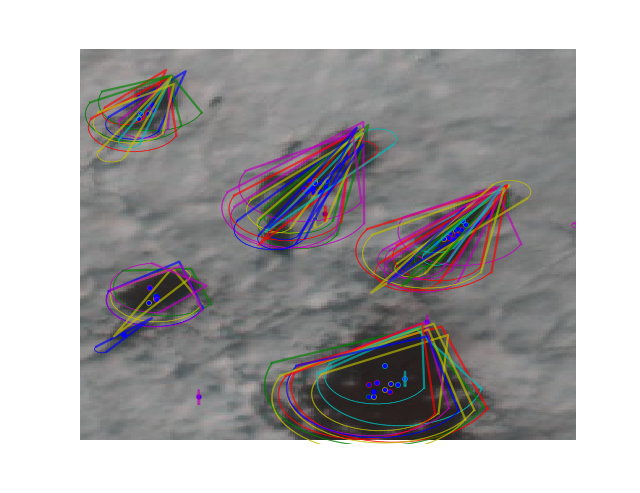

In [17]:
%matplotlib nbagg
p4id.plot_fans()
plt.savefig('/Users/klay6683/Desktop/fans_original.pdf')
plt.xlim(0,190)
plt.ylim(650, 370)
plt.savefig('/Users/klay6683/Desktop/fans_original_zoomed.pdf')

<IPython.core.display.Javascript object>


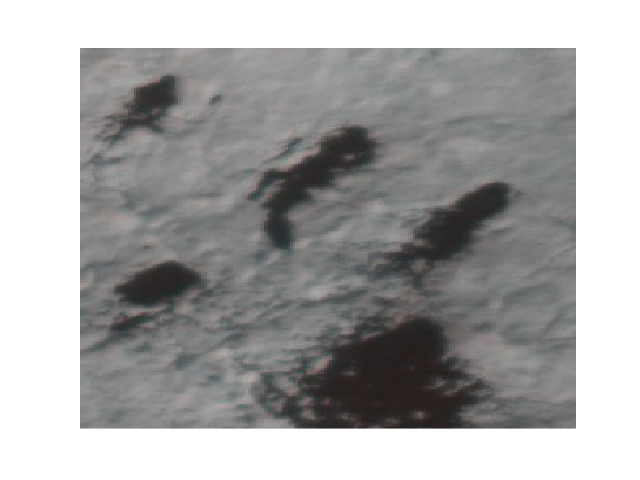

In [48]:
p4id.show_subframe()
plt.axis('off')
plt.xlim(0,190)
plt.ylim(650, 370)
plt.savefig("/Users/klay6683/Desktop/subframe_zoomed.pdf")

In [38]:
output_dir = Path('/Users/klay6683/Dropbox/data/planet4/inca_p4id_APF0000km4')
cm = ClusteringManager(dbname, scope='planet4', output_dir=output_dir,
                       output_format='hdf',min_distance=8)

In [39]:
cm.data_id = "APF0000km4"

In [40]:
cm.cluster_data(data)

/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


In [36]:
cm.final_blotches = cm.clustered_blotches
cm.final_fans = cm.clustered_fans

In [41]:
cm.do_the_fnotch()

In [42]:
cm.store_output('APF0000km4')

In [5]:
obsids = !cat /Users/klay6683/Dropbox/data/planet4/season2_3_image_names.txt

In [6]:
from ipyparallel import Client
c = Client()

In [7]:
lbview = c.load_balanced_view()

In [8]:
dview = c.direct_view()

In [9]:
dview.push({'dbname': str(db.dbname)})

<AsyncResult: finished>

In [10]:
results = lbview.map_async(process_image_name, obsids)

In [11]:
from iuvs.multitools import nb_progress_display

In [12]:
nb_progress_display(results, obsids)

# Applying cut to fnotches

In [43]:
output_dir = Path('/Users/klay6683/Dropbox/data/planet4/inca_p4id_APF0000km4/')

In [44]:
fnotch_fnames = list(output_dir.glob('*_fnotches.hdf'))

In [45]:
def filter_for_fans(x):
    if isinstance(x, planet4.markings.Fan):
        return x

def filter_for_blotches(x):
    if isinstance(x, planet4.markings.Blotch):
        return x

In [46]:
from planet4 import markings

def process_fnotch_fname(fname):
    outpath = output_dir
    outpath.mkdir(exist_ok=True)
    resman = io.ResultManager(fname)
    df = resman.fnotchdf 
    final_clusters = df.apply(markings.Fnotch.from_dataframe, axis=1).\
        apply(lambda x: x.get_marking(0.5))
    newfans = final_clusters[final_clusters.apply(filter_for_fans).notnull()]
    newblotches = final_clusters[final_clusters.apply(filter_for_blotches).notnull()]
    completefans = resman.fandf.append(newfans.apply(lambda x: x.store()),
                                       ignore_index=True)
    completeblotches = resman.blotchdf.append(newblotches.apply(lambda x: x.store()),
                                              ignore_index=True)
    completefans.to_hdf(str(outpath / resman.fanfile.name), 'df')
    completeblotches.to_hdf(str(outpath / resman.blotchfile.name), 'df')

In [47]:
for fnotch in fnotch_fnames:
    print(fnotch)
    process_fnotch_fname(fnotch)

/Users/klay6683/Dropbox/data/planet4/inca_p4id_APF0000km4/APF0000km4_fnotches.hdf
